In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [605]:
ls_returns = pd.read_pickle("long_short_returns.pkl")
interest_rates = pd.read_csv("Data/FEDFUNDS.csv", parse_dates=['observation_date'], index_col='observation_date')
gdp = pd.read_csv("Data/GDPC1.csv", parse_dates=['observation_date'], index_col='observation_date')
vix = pd.read_csv("Data/VIXCLS.csv", parse_dates=['observation_date'], index_col='observation_date')
inflation = pd.read_csv("Data/INFLATION.csv", parse_dates=["observation_date"], index_col="observation_date")
consumer_sentiment = pd.read_csv("Data/UMCSENT.csv", parse_dates=["observation_date"], index_col="observation_date")
credit_spread = pd.read_csv("Data/BAA10Y.csv", parse_dates=['observation_date'], index_col='observation_date')
TB = pd.read_csv("Data/DTB3.csv", parse_dates=['observation_date'], index_col='observation_date')
LGB = pd.read_csv("Data/LGB.csv", parse_dates=['observation_date'], index_col='observation_date')
industrial_production = pd.read_csv("Data/INDPRO.csv", parse_dates=['observation_date'], index_col='observation_date')
consumption = pd.read_csv("Data/PCE.csv", parse_dates=['observation_date'], index_col='observation_date')
oil_prices = pd.read_csv("Data/WPU0561.csv", parse_dates=['observation_date'], index_col='observation_date')
baa = pd.read_csv("Data/BAA.csv", parse_dates=['observation_date'], index_col='observation_date')
unemployment = pd.read_csv("Data/UNRATE.csv", parse_dates=['observation_date'], index_col='observation_date')
unemployment = unemployment/100
TB = TB/100
#inflation = inflation/100
baa = baa/100
LGB = LGB/100


interest_rates.rename(columns={"FEDFUNDS": "Interest_Rate"}, inplace=True)
gdp.rename(columns={"GDPC1": "Growth"}, inplace=True)
vix.rename(columns={"VIXCLS": "VIX"}, inplace=True)
inflation.rename(columns={"FPCPITOTLZGUSA": "Inflation"}, inplace=True)
#cpi = inflation_yearly.resample('M').ffill()
consumer_sentiment.rename(columns={"UMCSENT" : "Consumer_Sentiment"}, inplace=True)
credit_spread.rename(columns={"BAA10Y" : "Credit_Spread"}, inplace=True)
TB.rename(columns={"DTB3" : "Treasury Bill"}, inplace=True)
TB_shift = TB.shift(1)
LGB.rename(columns={"IRLTLT01USQ156N" : "LGB"}, inplace=True)
industrial_production.rename(columns={"INDPRO" : "Industrial_Production"}, inplace=True)
consumption.rename(columns={"PCE" : "Consumption"}, inplace=True)
oil_prices.rename(columns={"WPU0561" : "Oil_Prices"}, inplace=True)
ls_returns.index.name = "observation_date"

def to_month_end(df):
    # Wenn PeriodIndex: in Monatsende-DatetimeIndex umwandeln
    if isinstance(df.index, pd.PeriodIndex):
        df.index = df.index.to_timestamp('M')
    else:
        df.index = pd.to_datetime(df.index).to_period('M').to_timestamp('M')
    return df

ls_returns = to_month_end(ls_returns)
interest_rates = to_month_end(interest_rates)
gdp = to_month_end(gdp)
vix = to_month_end(vix)
vix = vix.groupby(vix.index).mean()
consumer_sentiment = to_month_end(consumer_sentiment)
TB = to_month_end(TB)
LGB = to_month_end(LGB)
industrial_production = to_month_end(industrial_production)
consumption = to_month_end(consumption)
oil_prices = to_month_end(oil_prices)
baa = to_month_end(baa)
inflation = to_month_end(inflation)
unemployment = to_month_end(unemployment)

# Ensure all are Series
TB_shift = TB_shift.squeeze()
LGB = LGB.squeeze()
baa = baa.squeeze()
inflation = inflation.squeeze()
industrial_production = industrial_production.squeeze()

TB_shift = TB_shift.asfreq('ME')
LGB = LGB.asfreq('ME')
baa = baa.asfreq('ME')
inflation = inflation.asfreq('ME')
industrial_production = industrial_production.asfreq('ME')

# Combine into one DataFrame using pd.concat
data = pd.concat(
    [TB_shift, LGB, baa, inflation, industrial_production, unemployment, ls_returns],
    axis=1,
    join='inner'
)

# Optional: assign column names if needed
data.columns = ['TB_shift', 'LGB', 'BAA', 'Inflation', 'IP', 'Unemployment', 'ls_returns']

#Derived Series
#MP: Monthly growth (industrial production)
MP = np.log(data.IP) - np.log(data.IP.shift(1))

#YP: annual growth (industrial production)
YP = np.log(data.IP) - np.log(data.IP.shift(12))

#RHO: real interest (ex post)
#TB_shift, inflation = TB_shift.align(inflation, join='inner')
RHO = data.TB_shift - data.Inflation

#DEI: Change in expected inflation
DEI = expected_inflation.shift(-1) - expected_inflation

#UPR: Rist premium
#baa, LGB = baa.align(LGB, join="inner")
UPR = data.BAA - data.LGB

#UTS: Term structure
#LGB, TB_shift = LGB.align(TB_shift, join='inner')
UTS = data.LGB - data.TB_shift

MP = to_month_end(MP)
YP = to_month_end(YP)
RHO = to_month_end(RHO)
DEI = to_month_end(DEI)
UPR = to_month_end(UPR)
UTS = to_month_end(UTS)
unexpected_inflation = to_month_end(unexpected_inflation)

# Deine Variablen (MP, YP, etc.) definieren

# Indizes ohne Duplikate (wie du schon machst)
RHO = RHO[~RHO.index.duplicated(keep='first')]
UTS = UTS[~UTS.index.duplicated(keep='first')]

# Gemeinsamen Index bestimmen, bei dem keine NaNs auftreten
common_index = MP.dropna().index
common_index = common_index.intersection(YP.dropna().index)
common_index = common_index.intersection(RHO.dropna().index)
common_index = common_index.intersection(DEI.dropna().index)
common_index = common_index.intersection(UPR.dropna().index)
common_index = common_index.intersection(UTS.dropna().index)

# Zusammenführen nur auf gemeinsamen Index
#macros = pd.concat([df.loc[common_index] for df in [MP, YP, RHO, DEI, UPR, UTS]], axis=1)
#macros.columns = ['MP', 'YP', 'RHO', 'DEI', 'UPR', 'UTS']

#ls_returns.index = ls_returns.index.to_timestamp()
ls_returns.index = pd.to_datetime(ls_returns.index)
ls_returns.index = ls_returns.index.normalize()
#macros.index = macros.index.normalize()
#macros.index = macros.index.to_timestamp()
#common_index = ls_returns.index.intersection(macros.index)
#ls_returns = ls_returns.loc[common_index]
#macros = macros.loc[common_index]
#macros


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 351 entries, 1983-02-01 to 2023-12-01
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TB_shift   343 non-null    float64
 1   LGB        351 non-null    float64
 2   BAA        351 non-null    float64
 3   Inflation  351 non-null    float64
 4   IP         351 non-null    float64
dtypes: float64(5)
memory usage: 16.5 KB
None


In [607]:
data['Unemployment']

observation_date
1983-01-31    0.104
1983-02-28    0.104
1983-03-31    0.103
1983-04-30    0.102
1983-05-31    0.101
              ...  
2018-02-28    0.041
2018-03-31    0.040
2018-04-30    0.040
2018-05-31    0.038
2018-06-30    0.040
Freq: ME, Name: Unemployment, Length: 426, dtype: float64

In [557]:
inflation

observation_date
1983-01-31    5.014653
1983-02-28    4.952545
1983-03-31    3.612261
1983-04-30    4.828054
1983-05-31    3.767326
                ...   
2024-12-31    3.234511
2025-01-31    3.930193
2025-02-28    3.516232
2025-03-31    4.184110
2025-04-30    3.980957
Freq: ME, Name: MEDCPIM158SFRBCLE, Length: 508, dtype: float64

In [269]:
#Conputing unexpected inflation

# 1. Berechne log Inflation
inflation_clean = np.log(inflation).dropna()

# 3. Fit ARIMA(0,0,1)
model = sm.tsa.ARIMA(inflation_clean, order=(0,0,1))
results = model.fit()

print(results.summary())

theta = results.params['ma.L1']
residuals = results.resid

# 4. Sicherstellen, dass es Series sind
inflation_clean = inflation_clean.squeeze()
residuals = residuals.squeeze()

expected_inflation = theta * residuals.shift(1)
#expected_inflation = pd.DataFrame(expected_inflation)
expected_inflation = expected_inflation[1:]
inflation = inflation[1:]

# Ensure both are Series with the same datetime index
inflation_series = inflation.squeeze().copy()
expected_inflation = expected_inflation.squeeze().copy()

# Option 1: Align explicitly
inflation_series, expected_inflation = inflation_series.align(expected_inflation, join='inner')

# Then compute
unexpected_inflation = inflation_series - expected_inflation

                               SARIMAX Results                                
Dep. Variable:      MEDCPIM158SFRBCLE   No. Observations:                  505
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -252.882
Date:                Tue, 27 May 2025   AIC                            511.764
Time:                        14:07:02   BIC                            524.437
Sample:                             0   HQIC                           516.735
                                - 505                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5680      0.030   -117.669      0.000      -3.627      -3.509
ma.L1          0.4529      0.026     17.363      0.000       0.402       0.504
sigma2         0.1593      0.006     26.140      0.0

/Users/justusschenk/Bachelorarbeit/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/justusschenk/Bachelorarbeit/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/justusschenk/Bachelorarbeit/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/justusschenk/Bachelorarbeit/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. for

In [617]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# 1. Log-Inflation berechnen
inflation_clean = np.log(inflation).dropna()

# 2. ARIMA(0,0,1) fitten
model = sm.tsa.ARIMA(inflation_clean, order=(0,0,1))
results = model.fit()

# 3. Parameter extrahieren
theta = results.params['ma.L1']
mu = results.params.get('const', 0)  # Falls Konstante vorhanden
residuals = results.resid

# 4. Erwartete Inflation korrekt berechnen
expected_inflation = mu + theta * residuals.shift(1)

# 5. Unerwartete Inflation berechnen (nur für verfügbare Werte)
unexpected_inflation = inflation_clean - expected_inflation
unexpected_inflation = unexpected_inflation.dropna()
print(results.summary())
unexpected_inflation

                               SARIMAX Results                                
Dep. Variable:      MEDCPIM158SFRBCLE   No. Observations:                  506
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -253.237
Date:                Mon, 16 Jun 2025   AIC                            512.475
Time:                        15:31:01   BIC                            525.155
Sample:                             0   HQIC                           517.448
                                - 506                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0381      0.030     34.222      0.000       0.979       1.098
ma.L1          0.4540      0.026     17.462      0.000       0.403       0.505
sigma2         0.1592      0.006     26.155      0.0

/Users/justusschenk/Bachelorarbeit/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/justusschenk/Bachelorarbeit/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/justusschenk/Bachelorarbeit/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/justusschenk/Bachelorarbeit/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. for

observation_date
1983-02-28    0.301112
1983-03-31    0.089328
1983-04-30    0.493379
1983-05-31    0.064163
1983-06-30   -0.174834
                ...   
2024-12-31    0.107140
2025-01-31    0.281961
2025-02-28    0.091300
2025-03-31    0.351757
2025-04-30    0.183747
Length: 505, dtype: float64

In [589]:
#Regression of LS-returns on Macro-Factors, following Nai-Fu Chen, Richard Roll and Stephen A. Ross in the Journal of Business

# First squeeze (if needed) and ensure datetime index is used
series_list = [MP, DEI, unexpected_inflation, UPR, UTS]
series_list = [squeeze if isinstance(squeeze, pd.Series) else squeeze.squeeze() for squeeze in series_list]

# Optional: set meaningful names (used as column names)
for s, name in zip(series_list, ['MP', 'DEI', 'UI', 'UPR', 'UTS']):
    s.name = name

# Align all using inner join on the index
X_df = pd.concat(series_list, axis=1, join='inner').dropna()
X = sm.add_constant(X_df)

Y_unaligned = ls_returns 
Y = Y_unaligned.reindex(X_df.index)

model = sm.OLS(Y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    LSR   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     1.960
Date:                Mon, 16 Jun 2025   Prob (F-statistic):             0.0846
Time:                        15:08:31   Log-Likelihood:                 643.36
No. Observations:                 291   AIC:                            -1275.
Df Residuals:                     285   BIC:                            -1253.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.006     -0.354      0.7

In [590]:
#Time Series Analysis
from statsmodels.tsa.stattools import adfuller

def run_adf_tests(df, signif=0.05):
    """
    Runs the Augmented Dickey-Fuller test on each column of a DataFrame.
    
    Parameters:
        df (pd.DataFrame): Each column is a time series.
        signif (float): Significance level for stationarity.

    Returns:
        pd.DataFrame: Summary table with ADF test results.
    """
    results = []
    
    for col in df.columns:
        series = df[col].dropna()
        adf_result = adfuller(series)
        p_val = adf_result[1]
        test_stat = adf_result[0]
        crit_vals = adf_result[4]
        is_stationary = p_val < signif
        
        results.append({
            'Variable': col,
            'ADF Statistic': round(test_stat, 4),
            'p-value': round(p_val, 4),
            'Stationary (p < {})'.format(signif): is_stationary,
            '1% Critical Value': crit_vals['1%'],
            '5% Critical Value': crit_vals['5%'],
            '10% Critical Value': crit_vals['10%']
        })

    return pd.DataFrame(results).set_index('Variable')

adf_summary = run_adf_tests(VAR_data)
print(adf_summary)

          ADF Statistic  p-value  Stationary (p < 0.05)  1% Critical Value  \
Variable                                                                     
LSR            -14.2397   0.0000                   True          -3.453102   
MP              -6.7375   0.0000                   True          -3.453262   
DEI            -15.7935   0.0000                   True          -3.453182   
UI              -3.4749   0.0087                   True          -3.453587   
UPR             -8.0029   0.0000                   True          -3.453423   
UTS             -3.7852   0.0031                   True          -3.453505   

          5% Critical Value  10% Critical Value  
Variable                                         
LSR               -2.871559           -2.572108  
MP                -2.871628           -2.572146  
DEI               -2.871593           -2.572127  
UI                -2.871771           -2.572222  
UPR               -2.871699           -2.572183  
UTS               -2.8717

VAR Model where the time series were derived from the paper of Nai-Fu Chen et al. (1986). To analyze the impact of one time series on the other, an impact response function was computed. The results show that a positive shock in the monthly change in production had a positive lagged (1) effect (0.45) on the portfolio returns. A positive shock in the unexpected inflation had a negative shock (-0.018), a positive shock in the risk premium did not have a significatn effect and the a positive shock in the term structure resulted in a positive effect (0.35) with a very slow decay. While the shocks from most of the time series reverted to zero within 10 periods, the show in the term structure did not.

In [622]:
from statsmodels.tsa.api import VAR

VAR_list = [ls_returns, MP, UPR.diff(), UTS]
VAR_list = [squeeze if isinstance(squeeze, pd.Series) else squeeze.squeeze() for squeeze in VAR_list]

for s, name in zip(VAR_list, ['LSR','MP', 'UPR', 'UTS']):
    s.name = name

VAR_data = pd.concat(VAR_list, axis=1, join="inner").dropna()

model = VAR(VAR_data)
results = model.fit(maxlags=8, ic='aic')
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 16, Jun, 2025
Time:                     15:33:30
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -40.5943
Nobs:                     291.000    HQIC:                  -40.8667
Log likelihood:           4356.94    FPE:                1.48870e-18
AIC:                     -41.0487    Det(Omega_mle):     1.31793e-18
--------------------------------------------------------------------
Results for equation LSR
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const         -0.001930         0.003560           -0.542           0.588
L1.LSR         0.181985         0.060074            3.029           0.002
L1.MP         -0.061524         0.261446           -0.235           0.814
L1.UPR         0

/Users/justusschenk/Bachelorarbeit/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


    Impulse Response  Period       IRF  Lower 95%  Upper 95%
0       LSR      LSR       0  1.000000   0.024467   0.028774
1       LSR      LSR       1  0.181985   0.001325   0.007365
2       LSR      LSR       2  0.012326  -0.002884   0.002973
3       LSR      LSR       3  0.007113  -0.001267   0.001199
4       LSR      LSR       4 -0.009103  -0.000971   0.000412
5       LSR      LSR       5 -0.002653  -0.000521   0.000232
6       LSR      LSR       6 -0.002697  -0.000463   0.000090
7       LSR      LSR       7 -0.000589  -0.000325   0.000085
8       LSR      LSR       8  0.000057  -0.000301   0.000076
9       LSR      LSR       9  0.000516  -0.000267   0.000078
10      LSR      LSR      10  0.000735  -0.000250   0.000078
44    MPUPR      LSR       0  0.000000   0.000000   0.000000
45    MPUPR      LSR       1 -0.061524  -0.003162   0.002769
46    MPUPR      LSR       2  0.411190  -0.000515   0.005443
47    MPUPR      LSR       3  0.032563  -0.000880   0.001297
48    MPUPR      LSR    

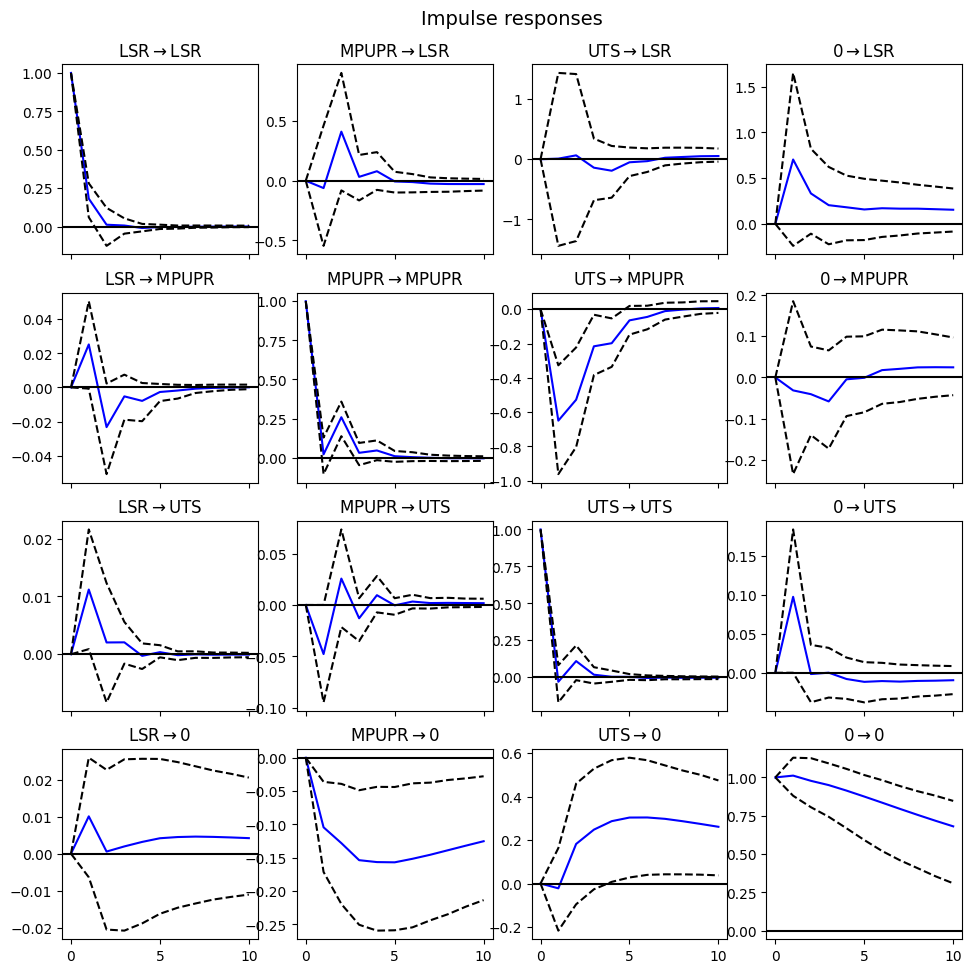

In [619]:
#Impulse Response Function
irf = results.irf(10)
irf.plot(orth=False, stderr_type='mc', repl=1000)

"""
    def get_irf_summary(irf, impulse, response):
    imp_idx = irf.model.names.index(impulse)
    resp_idx = irf.model.names.index(response)
    
    df = pd.DataFrame({
        "Period": range(irf.irfs.shape[0]),
        "IRF": irf.irfs[:, resp_idx, imp_idx]
    })
    return df

    irf_mp = get_irf_summary(irf, 'MP', 'LSR')
    print(irf_mp)
"""
def collect_all_irfs(irf_obj, alpha=0.05):
    """
    Collect IRFs and Monte Carlo confidence intervals for all impulse-response pairs.

    Parameters:
        irf_obj : statsmodels VAR IRAnalysis object
        alpha : significance level (e.g., 0.05 for 95% CI)

    Returns:
        pd.DataFrame with IRF values and CIs
    """
    # Use alpha as a positional argument
    lower, upper = irf_obj.errband_mc(alpha, repl=1000)

    variables = irf_obj.model.names
    horizon = irf_obj.irfs.shape[0]

    rows = []
    for imp_idx, impulse in enumerate(variables):
        for resp_idx, response in enumerate(variables):
            for t in range(horizon):
                rows.append({
                    'Impulse': impulse,
                    'Response': response,
                    'Period': t,
                    'IRF': irf_obj.irfs[t, resp_idx, imp_idx],
                    'Lower 95%': lower[t, resp_idx, imp_idx],
                    'Upper 95%': upper[t, resp_idx, imp_idx]
                })

    return pd.DataFrame(rows)



irf_summary = collect_all_irfs(irf)
print(irf_summary[irf_summary["Response"] == 'LSR'])



In [576]:
#Model diagnostics

# Check for autocorrelation (Ljung-Box)
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import ccf

for col in results.resid.columns:
    print(f"{col} residuals Ljung-Box p-value:")
    print(acorr_ljungbox(results.resid[col], lags=[10], return_df=True))

# Check for normality
from statsmodels.stats.stattools import jarque_bera
jb = results.test_normality()
print('Jarque Bera Test: ', jb.summary())

#Stability Test
print('Model is stable: ' , results.is_stable(verbose=True))




LSR residuals Ljung-Box p-value:
     lb_stat  lb_pvalue
10  10.15552   0.426957
MP residuals Ljung-Box p-value:
      lb_stat  lb_pvalue
10  10.696672   0.381633
DEI residuals Ljung-Box p-value:
      lb_stat  lb_pvalue
10  16.553168   0.084855
UI residuals Ljung-Box p-value:
      lb_stat  lb_pvalue
10  17.217392    0.06969
UPR residuals Ljung-Box p-value:
      lb_stat  lb_pvalue
10  28.779909   0.001352
UTS residuals Ljung-Box p-value:
      lb_stat  lb_pvalue
10  13.484601   0.197824
Jarque Bera Test:  normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         2444.          21.03   0.000 12
----------------------------------------
Eigenvalues of VAR(1) rep
0.949548818188471
0.8029964667317591
0.48504045068275314
0.4055808120005697
0.4454093101300215
0.4454093101300215
0.335507781332394
0.335507781332394
0.1043119

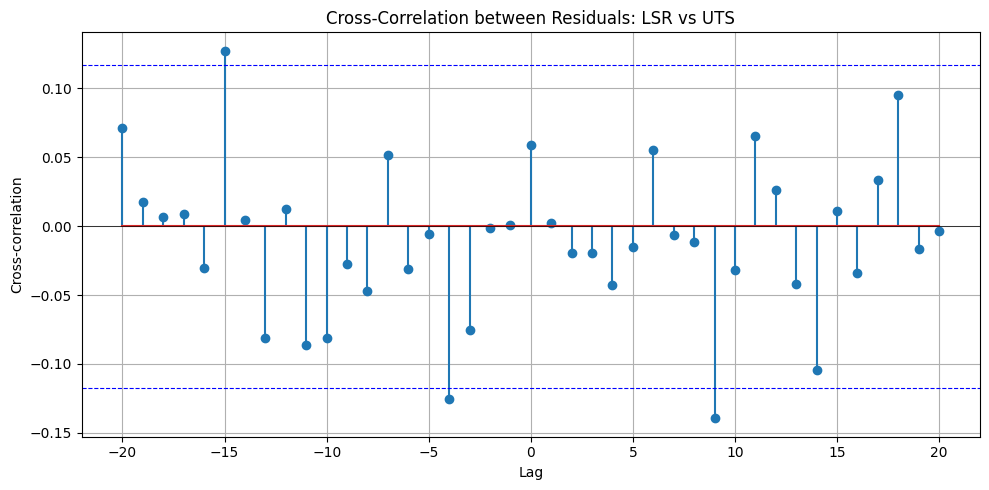

In [620]:
#Cross correlation or VAR residuals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import ccf

# Get residuals
residuals = results.resid

# Choose two variables to analyze cross-correlation
var1 = 'LSR'
var2 = 'UTS'

# Ensure no NaNs
x = residuals[var1].dropna().values
y = residuals[var2].dropna().values

# Compute CCF: correlation of x with lagged versions of y
def compute_ccf(x, y, nlags=20):
    x = (x - np.mean(x)) / np.std(x)
    y = (y - np.mean(y)) / np.std(y)
    ccf_vals = [np.corrcoef(x[max_lag:], y[max_lag - lag:len(y) - lag])[0, 1]
                if lag > 0 else
                np.corrcoef(x[:len(x)+lag], y[-lag:])[0, 1]
                for lag in range(-nlags, nlags+1)]
    return np.array(ccf_vals)

# Compute and plot
max_lag = 20
ccf_values = compute_ccf(x, y, max_lag)
lags = np.arange(-max_lag, max_lag + 1)

plt.figure(figsize=(10, 5))
plt.stem(lags, ccf_values)
plt.axhline(0, color='black', linewidth=0.5)
plt.axhline(2/np.sqrt(len(x)), color='blue', linestyle='--', linewidth=0.8)  # ~95% CI
plt.axhline(-2/np.sqrt(len(x)), color='blue', linestyle='--', linewidth=0.8)
plt.title(f'Cross-Correlation between Residuals: {var1} vs {var2}')
plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.grid(True)
plt.tight_layout()
plt.show()



Jarque-Bera Test for LSR residuals:
Statistic: 109.5497, P-value: 0.0000
Skewness: 0.0702, Kurtosis: 6.0129

Jarque-Bera Test for MP residuals:
Statistic: 1755.2674, P-value: 0.0000
Skewness: -1.3151, Kurtosis: 14.7834

Jarque-Bera Test for DEI residuals:
Statistic: 146.1555, P-value: 0.0000
Skewness: 0.2159, Kurtosis: 6.4570

Jarque-Bera Test for UI residuals:
Statistic: 532.5216, P-value: 0.0000
Skewness: -0.9870, Kurtosis: 9.3503

Jarque-Bera Test for UPR residuals:
Statistic: 90.0829, P-value: 0.0000
Skewness: 0.1123, Kurtosis: 5.7259

Jarque-Bera Test for UTS residuals:
Statistic: 19.6588, P-value: 0.0001
Skewness: 0.0644, Kurtosis: 4.2712


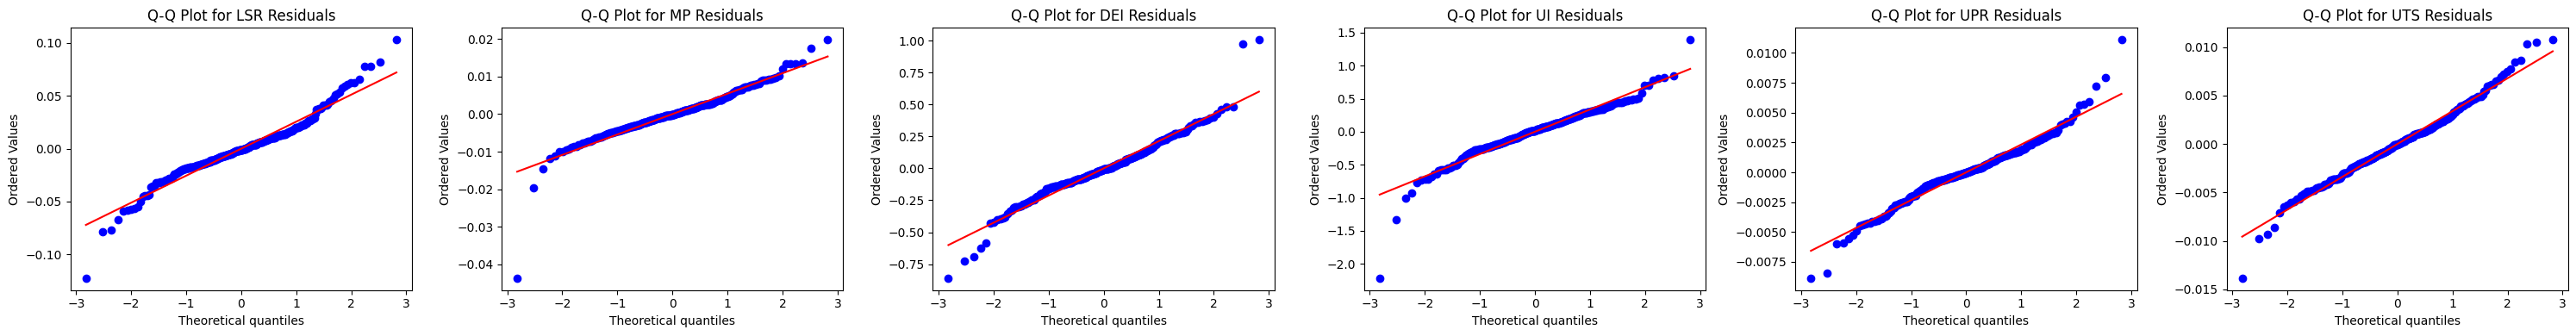

In [578]:
#Nomarlity Check for VAR Residuals
import statsmodels.stats.api as sms

# After fitting your VAR model (results object from above)
# Access residuals: results.resid (This is a pandas DataFrame)

# Jarque-Bera test for each residual series
for col in results.resid.columns:
    jb_test = sms.jarque_bera(results.resid[col])
    print(f"\nJarque-Bera Test for {col} residuals:")
    print(f"Statistic: {jb_test[0]:.4f}, P-value: {jb_test[1]:.4f}")
    print(f"Skewness: {jb_test[2]:.4f}, Kurtosis: {jb_test[3]:.4f}")

# You can also plot Q-Q plots for visual inspection:
import matplotlib.pyplot as plt
import scipy.stats as stats

fig, axes = plt.subplots(1, results.resid.shape[1], figsize=(5 * results.resid.shape[1], 4))
if results.resid.shape[1] == 1:
    axes = [axes] # Ensure axes is iterable even for a single series
for i, col in enumerate(results.resid.columns):
    stats.probplot(results.resid[col], dist="norm", plot=axes[i])
    axes[i].set_title(f'Q-Q Plot for {col} Residuals')
plt.tight_layout()
plt.show()

Residuals of LSR are uncorrelated (ACF shows this)

Normality: QQ-Plots show that the distributions of the residuals do not deviate too much from the normal distribution. The test-statistic of the Jarque-Bera-Test on the otherhand shows that the residuals are significantly not normal. In the context of financial data this is expected. The result of the Jarque-Bera-Test is predominantly influenced by the leptokurtic behavior of the data.

Residuals are not normal. If I can get robust inference using the VAR model -> great


Otherwise, bootstrapping might be the solution -> complex

VAR Model Info:
- Variables: ['LSR', 'MP', 'UPR', 'UTS']
- Observations: 291
- Lag order: 2
- Equations: 4

Running 1000 bootstrap iterations...
Progress: 100/1000 (99 successful)
Progress: 200/1000 (199 successful)
Progress: 300/1000 (299 successful)
Progress: 400/1000 (399 successful)
Progress: 500/1000 (499 successful)
Progress: 600/1000 (599 successful)
Progress: 700/1000 (699 successful)
Progress: 800/1000 (799 successful)
Progress: 900/1000 (899 successful)
Progress: 1000/1000 (999 successful)

Completed: 1000/1000 successful iterations
Bootstrap Inference Results:
    coefficient  bootstrap_se  t_statistic  p_value  ci_lower_95%  \
0     -0.000838      0.003514    -0.238489    0.802     -0.007745   
1      0.000920      0.000729     1.261724    0.214     -0.000560   
2      0.000345      0.000336     1.027864    0.306     -0.000340   
3      0.001845      0.000304     6.064380    0.000      0.001277   
4      0.002083      0.062712     0.033213    0.986     -0.122348   
5     -0

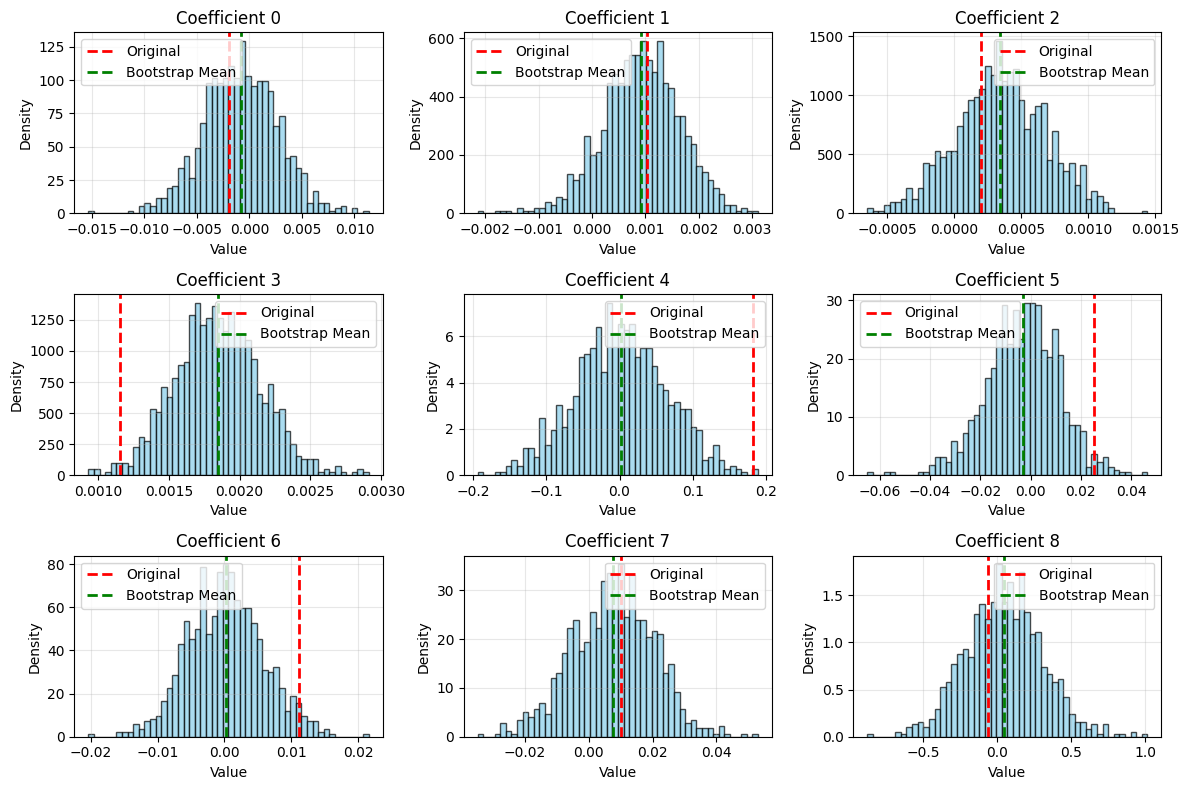

VAR Model Bootstrap Summary
Model: VAR(2)
Variables: LSR, MP, UPR, UTS
Observations: 291
Bootstrap iterations: 1000
Bootstrap success rate: 100.0%

Bootstrap Coefficient Results
Total parameters: 36
Parameters per equation: 9
----------------------------------------------------------------------------------------------------
Parameter            Equation   Coefficient  Bootstrap SE t-stat   P>|t|    [95.0% CI]         Sig 
----------------------------------------------------------------------------------------------------
const                LSR        -0.000838    0.003514     -0.238   0.802    [ -0.008,   0.006]     
L1.LSR               LSR        0.000920     0.000729     1.262    0.214    [ -0.001,   0.002]     
L1.MP                LSR        0.000345     0.000336     1.028    0.306    [ -0.000,   0.001]     
L1.UPR               LSR        0.001845     0.000304     6.064    0.000    [  0.001,   0.002] *** 
L1.UTS               LSR        0.002083     0.062712     0.033    0.986

In [623]:
import numpy as np
import pandas as pd
from statsmodels.tsa.vector_ar.var_model import VAR
from scipy import stats
import matplotlib.pyplot as plt

def bootstrap_var_residuals_targeted(results, n_bootstrap=1000, random_state=None):
    """
    Bootstrap specifically designed for your VAR model setup
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    # Extract key components
    residuals = results.resid.values if hasattr(results.resid, 'values') else results.resid
    fitted_values = results.fittedvalues.values if hasattr(results.fittedvalues, 'values') else results.fittedvalues
    original_data = results.endog.values if hasattr(results.endog, 'values') else results.endog
    n_obs, n_vars = residuals.shape
    lag_order = results.k_ar
    
    print(f"VAR Model Info:")
    print(f"- Variables: {results.names}")
    print(f"- Observations: {n_obs}")
    print(f"- Lag order: {lag_order}")
    print(f"- Equations: {n_vars}")
    
    bootstrap_coefs = []
    bootstrap_fits = []
    successful_iterations = 0
    
    print(f"\nRunning {n_bootstrap} bootstrap iterations...")
    
    for i in range(n_bootstrap):
        if (i + 1) % 100 == 0:
            print(f"Progress: {i + 1}/{n_bootstrap} ({successful_iterations} successful)")
        
        try:
            # Resample residuals (preserving cross-equation correlation structure)
            bootstrap_indices = np.random.choice(n_obs, size=n_obs, replace=True)
            bootstrap_residuals = residuals[bootstrap_indices]
            
            # Reconstruct bootstrap data
            bootstrap_data = fitted_values + bootstrap_residuals
            
            # Convert back to DataFrame with proper column names
            bootstrap_df = pd.DataFrame(bootstrap_data, columns=results.names)
            
            # Fit new VAR model with same specification as original
            bootstrap_model = VAR(bootstrap_df)
            bootstrap_fit = bootstrap_model.fit(
                maxlags=lag_order, 
                ic=None,  # Use fixed lag order
                trend='c'  # Assuming constant trend (adjust if needed)
            )
            bootstrap_fits.append(bootstrap_fit)    
            
            # Extract and store coefficients
            coef_vector = bootstrap_fit.params.values.flatten()
            bootstrap_coefs.append(coef_vector)
            successful_iterations += 1

            #Store residuals for later analysis
            last_bootstrap_residuals = bootstrap_fit.resid
            bootstrap_model = bootstrap_fit
            
        except Exception as e:
            # Only print first few errors for debugging
            if i < 5:
                print(f"  Error in iteration {i}: {str(e)[:100]}...")
            continue
    
    print(f"\nCompleted: {successful_iterations}/{n_bootstrap} successful iterations")
    
    if successful_iterations == 0:
        raise ValueError("No bootstrap iterations succeeded. Check model specification.")
    
    if successful_iterations < n_bootstrap * 0.5:
        print(f"Warning: Only {successful_iterations/n_bootstrap:.1%} of bootstrap iterations succeeded.")
    
    # Convert to numpy array
    bootstrap_coefs = np.array(bootstrap_coefs)
    
    # Calculate bootstrap statistics
    coef_means = np.mean(bootstrap_coefs, axis=0)
    coef_stds = np.std(bootstrap_coefs, axis=0)
    coef_ci_lower = np.percentile(bootstrap_coefs, 2.5, axis=0)
    coef_ci_upper = np.percentile(bootstrap_coefs, 97.5, axis=0)
    
    return {
        'bootstrap_coefficients': bootstrap_coefs,
        'coefficient_means': coef_means,
        'coefficient_stds': coef_stds,
        'coefficient_ci_lower': coef_ci_lower,
        'coefficient_ci_upper': coef_ci_upper,
        'original_results': results,
        'n_successful_iterations': successful_iterations,
        'success_rate': successful_iterations / n_bootstrap,
        'last_bootstrap_residuals': last_bootstrap_residuals,
        'bootstrap_model': bootstrap_model,
        'bootstrap_fits': bootstrap_fits
    }
    """
    Bootstrap specifically designed for your VAR model setup
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    # Extract key components
    residuals = results.resid.values  # Shape: (n_obs, n_equations)
    fitted_values = results.fittedvalues.values
    original_data = results.endog.values
    n_obs, n_vars = residuals.shape
    lag_order = results.k_ar
    
    print(f"VAR Model Info:")
    print(f"- Variables: {results.names}")
    print(f"- Observations: {n_obs}")
    print(f"- Lag order: {lag_order}")
    print(f"- Equations: {n_vars}")
    
    bootstrap_coefs = []
    successful_iterations = 0
    
    print(f"\nRunning {n_bootstrap} bootstrap iterations...")
    
    for i in range(n_bootstrap):
        if (i + 1) % 100 == 0:
            print(f"Progress: {i + 1}/{n_bootstrap} ({successful_iterations} successful)")
        
        try:
            # Resample residuals (preserving cross-equation correlation structure)
            bootstrap_indices = np.random.choice(n_obs, size=n_obs, replace=True)
            bootstrap_residuals = residuals[bootstrap_indices]
            
            # Reconstruct bootstrap data
            bootstrap_data = fitted_values + bootstrap_residuals
            
            # Convert back to DataFrame with proper column names
            bootstrap_df = pd.DataFrame(bootstrap_data, columns=results.names)
            
            # Fit new VAR model with same specification as original
            bootstrap_model = VAR(bootstrap_df)
            bootstrap_fit = bootstrap_model.fit(
                maxlags=lag_order, 
                ic=None,  # Use fixed lag order
                trend='c'  # Assuming constant trend (adjust if needed)
            )
            
            # Extract and store coefficients
            coef_vector = bootstrap_fit.params.values.flatten()
            bootstrap_coefs.append(coef_vector)
            successful_iterations += 1
            
        except Exception as e:
            # Only print first few errors for debugging
            if i < 5:
                print(f"  Error in iteration {i}: {str(e)[:100]}...")
            continue
    
    print(f"\nCompleted: {successful_iterations}/{n_bootstrap} successful iterations")
    
    if successful_iterations == 0:
        raise ValueError("No bootstrap iterations succeeded. Check model specification.")
    
    if successful_iterations < n_bootstrap * 0.5:
        print(f"Warning: Only {successful_iterations/n_bootstrap:.1%} of bootstrap iterations succeeded.")
    
    # Convert to numpy array
    bootstrap_coefs = np.array(bootstrap_coefs)
    
    # Calculate bootstrap statistics
    coef_means = np.mean(bootstrap_coefs, axis=0)
    coef_stds = np.std(bootstrap_coefs, axis=0)
    coef_ci_lower = np.percentile(bootstrap_coefs, 2.5, axis=0)
    coef_ci_upper = np.percentile(bootstrap_coefs, 97.5, axis=0)


    irf = bootstrap_fit.irf(10)
    irf.plot(orth=False, stderr_type='mc', repl=1000)

    return {
        'bootstrap_coefficients': bootstrap_coefs,
        'coefficient_means': coef_means,
        'coefficient_stds': coef_stds,
        'coefficient_ci_lower': coef_ci_lower,
        'coefficient_ci_upper': coef_ci_upper,
        'original_results': results,
        'n_successful_iterations': successful_iterations,
        'success_rate': successful_iterations / n_bootstrap,
        'bootstrap_residuals': bootstrap_coefs[''],
        'bootstrap_fits': bootstrap_fits
    }

def get_bootstrap_inference(bootstrap_results, coefficient_index=None, alpha=0.05):
    """
    Extract inference statistics from bootstrap results
    
    Parameters:
    -----------
    bootstrap_results : dict
        Results from bootstrap_var_residuals
    coefficient_index : int or None
        Specific coefficient index to analyze (None for all)
    alpha : float
        Significance level for confidence intervals
    
    Returns:
    --------
    DataFrame with inference statistics
    """
    coefs = bootstrap_results['bootstrap_coefficients']
    
    if coefficient_index is not None:
        coefs = coefs[:, coefficient_index:coefficient_index+1]
    
    # Calculate statistics
    means = np.mean(coefs, axis=0)
    stds = np.std(coefs, axis=0)
    
    # Confidence intervals
    ci_lower = np.percentile(coefs, (alpha/2) * 100, axis=0)
    ci_upper = np.percentile(coefs, (1 - alpha/2) * 100, axis=0)
    
    # T-statistics (using bootstrap standard errors)
    t_stats = means / stds
    
    # P-values (two-tailed test, using bootstrap distribution)
    p_values = []
    for i in range(coefs.shape[1]):
        # Count how many bootstrap samples have opposite sign from mean
        opposite_sign_count = np.sum(np.sign(coefs[:, i]) != np.sign(means[i]))
        p_val = 2 * min(opposite_sign_count, len(coefs) - opposite_sign_count) / len(coefs)
        p_values.append(p_val)
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'coefficient': means,
        'bootstrap_se': stds,
        't_statistic': t_stats,
        'p_value': p_values,
        f'ci_lower_{int((1-alpha)*100)}%': ci_lower,
        f'ci_upper_{int((1-alpha)*100)}%': ci_upper
    })
    
    return results_df

def plot_bootstrap_distribution(bootstrap_results, coefficient_indices=None, figsize=(12, 8)):
    """
    Plot bootstrap distribution of coefficients
    """
    coefs = bootstrap_results['bootstrap_coefficients']
    original_coefs = bootstrap_results['original_results'].params.values.flatten()
    
    if coefficient_indices is None:
        coefficient_indices = range(min(9, coefs.shape[1]))  # Plot first 9 coefficients
    
    n_plots = len(coefficient_indices)
    n_cols = min(3, n_plots)
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_plots == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes
    else:
        axes = axes.flatten()
    
    for i, coef_idx in enumerate(coefficient_indices):
        ax = axes[i] if n_plots > 1 else axes[0]
        
        # Plot histogram of bootstrap coefficients
        ax.hist(coefs[:, coef_idx], bins=50, alpha=0.7, density=True, 
                color='skyblue', edgecolor='black')
        
        # Add vertical line for original coefficient
        ax.axvline(original_coefs[coef_idx], color='red', linestyle='--', 
                  linewidth=2, label='Original')
        
        # Add vertical line for bootstrap mean
        bootstrap_mean = np.mean(coefs[:, coef_idx])
        ax.axvline(bootstrap_mean, color='green', linestyle='--', 
                  linewidth=2, label='Bootstrap Mean')
        
        ax.set_title(f'Coefficient {coef_idx}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Hide empty subplots
    for i in range(n_plots, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def create_bootstrap_summary(bootstrap_results, equation_name=None):
    """
    Create a summary table comparing original and bootstrap results
    """
    original = bootstrap_results['original_results']
    
    # Get original coefficient names and values
    original_params = original.params
    bootstrap_means = bootstrap_results['coefficient_means']
    bootstrap_stds = bootstrap_results['coefficient_stds']
    bootstrap_ci_lower = bootstrap_results['coefficient_ci_lower']
    bootstrap_ci_upper = bootstrap_results['coefficient_ci_upper']
    
    # Create comparison DataFrame
    if equation_name and equation_name in original_params.index:
        # Focus on specific equation
        eq_params = original_params.loc[equation_name]
        eq_stderr = original.stderr.loc[equation_name]
        
        # Find corresponding bootstrap indices (this is approximate)
        n_params_per_eq = len(eq_params)
        eq_index = list(original_params.index).index(equation_name)
        start_idx = eq_index * n_params_per_eq
        end_idx = start_idx + n_params_per_eq
        
        comparison_df = pd.DataFrame({
            'Variable': eq_params.index,
            'Original_Coef': eq_params.values,
            'Original_SE': eq_stderr.values,
            'Bootstrap_Coef': bootstrap_means[start_idx:end_idx],
            'Bootstrap_SE': bootstrap_stds[start_idx:end_idx],
            'Bootstrap_CI_Lower': bootstrap_ci_lower[start_idx:end_idx],
            'Bootstrap_CI_Upper': bootstrap_ci_upper[start_idx:end_idx]
        })
    else:
        # Full model summary
        all_param_names = []
        all_original_coefs = []
        all_original_se = []
        
        for eq_name in original.names:
            eq_params = original_params.loc[eq_name]
            eq_stderr = original.stderr.loc[eq_name]
            
            for param_name in eq_params.index:
                all_param_names.append(f"{eq_name}_{param_name}")
                all_original_coefs.append(eq_params[param_name])
                all_original_se.append(eq_stderr[param_name])
        
        comparison_df = pd.DataFrame({
            'Parameter': all_param_names,
            'Original_Coef': all_original_coefs,
            'Original_SE': all_original_se,
            'Bootstrap_Coef': bootstrap_means,
            'Bootstrap_SE': bootstrap_stds,
            'Bootstrap_CI_Lower': bootstrap_ci_lower,
            'Bootstrap_CI_Upper': bootstrap_ci_upper
        })
    
    # Add significance indicators
    comparison_df['Bootstrap_Significant'] = (
        (comparison_df['Bootstrap_CI_Lower'] > 0) | 
        (comparison_df['Bootstrap_CI_Upper'] < 0)
    )
    
    return comparison_df

# Example usage with your model:
    """
    Block bootstrap for VAR residuals (preserves temporal dependencies)
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    residuals = results.resid.values
    n_obs, n_vars = residuals.shape
    
    # Default block length
    if block_length is None:
        block_length = max(1, int(np.sqrt(n_obs)))
    
    bootstrap_coefs = []
    
    print(f"Running block bootstrap with block length {block_length}...")
    
    for i in range(n_bootstrap):
        try:
            # Generate block bootstrap sample
            bootstrap_residuals = []
            current_length = 0
            
            while current_length < n_obs:
                # Random starting point for block
                start_idx = np.random.randint(0, n_obs - block_length + 1)
                block = residuals[start_idx:start_idx + block_length]
                
                # Add block (may truncate if it exceeds needed length)
                remaining = n_obs - current_length
                if len(block) > remaining:
                    block = block[:remaining]
                
                bootstrap_residuals.append(block)
                current_length += len(block)
            
            bootstrap_residuals = np.vstack(bootstrap_residuals)[:n_obs]
            
            # Reconstruct data
            fitted_values = results.fittedvalues.values
            bootstrap_data = fitted_values + bootstrap_residuals
            
            # Fit VAR
            bootstrap_model = VAR(bootstrap_data)
            bootstrap_fit = bootstrap_model.fit(maxlags=results.k_ar, ic=None, trend='c' if results.k_trend > 0 else 'n')
            
            bootstrap_coefs.append(bootstrap_fit.params.values.flatten())

            
        except Exception as e:
            if i < 3:
                print(f"Block bootstrap error in iteration {i}: {e}")
            continue
    
    if len(bootstrap_coefs) == 0:
        raise ValueError("Block bootstrap also failed. Check your VAR model specification.")
    
    bootstrap_coefs = np.array(bootstrap_coefs)
    print(f"Block bootstrap: {len(bootstrap_coefs)} successful iterations")
    
    return {
        'bootstrap_coefficients': bootstrap_coefs,
        'coefficient_means': np.mean(bootstrap_coefs, axis=0),
        'coefficient_stds': np.std(bootstrap_coefs, axis=0),
        'coefficient_ci_lower': np.percentile(bootstrap_coefs, 2.5, axis=0),
        'coefficient_ci_upper': np.percentile(bootstrap_coefs, 97.5, axis=0),
        'original_results': results,
        'n_successful_iterations': len(bootstrap_coefs)
    }


bootstrap_results = bootstrap_var_residuals_targeted(results, n_bootstrap=1000, random_state=42)

# Get inference statistics
inference_stats = get_bootstrap_inference(bootstrap_results)
print("Bootstrap Inference Results:")
print(inference_stats)

# Plot bootstrap distributions
plot_bootstrap_distribution(bootstrap_results)

def create_bootstrap_model_summary(bootstrap_results, alpha=0.05):

    """
    Create a comprehensive model summary using bootstrap results
    """
    original = bootstrap_results['original_results']
    bootstrap_coefs = bootstrap_results['bootstrap_coefficients']
    
    print("="*80)
    print("VAR Model Summary with Bootstrap Inference")
    print("="*80)
    print(f"Model: VAR({original.k_ar})")
    print(f"Variables: {', '.join(original.names)}")
    print(f"Observations: {original.nobs}")
    print(f"Bootstrap iterations: {bootstrap_results['n_successful_iterations']}")
    print(f"Bootstrap success rate: {bootstrap_results['success_rate']:.1%}")
    print("-"*80)
    
    # Get parameter structure
    param_names = []
    original_coefs = []
    original_se = []
    original_tvals = []
    original_pvals = []
    
    for eq_name in original.names:
        eq_params = original.params.loc[eq_name]
        eq_stderr = original.stderr.loc[eq_name]
        eq_tvalues = original.tvalues.loc[eq_name]
        eq_pvalues = original.pvalues.loc[eq_name]
        
        for param_name in eq_params.index:
            param_names.append(f"{eq_name}.{param_name}")
            original_coefs.append(eq_params[param_name])
            original_se.append(eq_stderr[param_name])
            original_tvals.append(eq_tvalues[param_name])
            original_pvals.append(eq_pvalues[param_name])
    
    # Bootstrap statistics
    bootstrap_means = bootstrap_results['coefficient_means']
    bootstrap_se = bootstrap_results['coefficient_stds']
    bootstrap_ci_lower = bootstrap_results['coefficient_ci_lower']
    bootstrap_ci_upper = bootstrap_results['coefficient_ci_upper']
    
    # Bootstrap t-statistics and p-values
    bootstrap_t = bootstrap_means / bootstrap_se
    
    # Bootstrap p-values (two-tailed test using bootstrap distribution)
    bootstrap_pvals = []
    for i in range(len(bootstrap_means)):
        # Count proportion of bootstrap samples with opposite sign
        coef_samples = bootstrap_coefs[:, i]
        if bootstrap_means[i] == 0:
            p_val = 1.0
        else:
            # Two-tailed test: proportion of samples with opposite sign * 2
            opposite_sign_prop = np.mean(np.sign(coef_samples) != np.sign(bootstrap_means[i]))
            p_val = 2 * min(opposite_sign_prop, 1 - opposite_sign_prop)
        bootstrap_pvals.append(p_val)
    
    # Create summary by equation
    param_idx = 0
    for eq_name in original.names:
        print(f"\nResults for equation {eq_name}")
        print("="*60)
        print(f"{'Variable':<12} {'Coef':<10} {'Bootstrap SE':<12} {'t-stat':<8} {'P>|t|':<8} {'[{:.1f}% Conf. Int.]':<20}".format((1-alpha)*100))
        print("-"*80)
        
        eq_params = original.params.loc[eq_name]
        for param_name in eq_params.index:
            coef = bootstrap_means[param_idx]
            se = bootstrap_se[param_idx]
            t_stat = bootstrap_t[param_idx]
            p_val = bootstrap_pvals[param_idx]
            ci_lower = bootstrap_ci_lower[param_idx]
            ci_upper = bootstrap_ci_upper[param_idx]
            
            # Significance stars
            stars = ""
            if p_val < 0.001:
                stars = "***"
            elif p_val < 0.01:
                stars = "**"
            elif p_val < 0.05:
                stars = "*"
            elif p_val < 0.1:
                stars = "."
            
            print(f"{param_name:<12} {coef:<10.6f} {se:<12.6f} {t_stat:<8.3f} {p_val:<8.3f} [{ci_lower:>8.3f}, {ci_upper:>8.3f}] {stars}")
            param_idx += 1
    
    print("\n" + "="*80)
    print("Significance codes: 0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1")
    print("Standard errors and confidence intervals based on bootstrap distribution")
    print("="*80)
    
    return {
        'parameter_names': param_names,
        'bootstrap_coefficients': bootstrap_means,
        'bootstrap_se': bootstrap_se,
        'bootstrap_t_stats': bootstrap_t,
        'bootstrap_p_values': bootstrap_pvals,
        'confidence_intervals': list(zip(bootstrap_ci_lower, bootstrap_ci_upper))
    }

def compare_original_vs_bootstrap(bootstrap_results, equation_name=None):
    """
    Side-by-side comparison of original vs bootstrap results
    """
    original = bootstrap_results['original_results']
    
    if equation_name:
        equations = [equation_name]
    else:
        equations = original.names
    
    print("="*100)
    print("Comparison: Original vs Bootstrap Results")
    print("="*100)
    
    for eq_name in equations:
        print(f"\nEquation: {eq_name}")
        print("-"*90)
        print(f"{'Variable':<12} {'Original':<25} {'Bootstrap':<25} {'Difference':<15}")
        print(f"{'':>12} {'Coef':<8} {'SE':<8} {'P-val':<8} {'Coef':<8} {'SE':<8} {'P-val':<8} {'Coef':<8}")
        print("-"*90)
        
        eq_params = original.params.loc[eq_name]
        eq_stderr = original.stderr.loc[eq_name]
        eq_pvalues = original.pvalues.loc[eq_name]
        
        # Find bootstrap indices for this equation
        param_idx = 0
        for i, other_eq in enumerate(original.names):
            if other_eq == eq_name:
                break
            param_idx += len(original.params.loc[other_eq])
        
        for j, param_name in enumerate(eq_params.index):
            orig_coef = eq_params[param_name]
            orig_se = eq_stderr[param_name]
            orig_pval = eq_pvalues[param_name]
            
            boot_coef = bootstrap_results['coefficient_means'][param_idx + j]
            boot_se = bootstrap_results['coefficient_stds'][param_idx + j]
            # Calculate bootstrap p-value
            coef_samples = bootstrap_results['bootstrap_coefficients'][:, param_idx + j]
            if boot_coef == 0:
                boot_pval = 1.0
            else:
                opposite_sign_prop = np.mean(np.sign(coef_samples) != np.sign(boot_coef))
                boot_pval = 2 * min(opposite_sign_prop, 1 - opposite_sign_prop)
            
            coef_diff = boot_coef - orig_coef
            
            print(f"{param_name:<12} {orig_coef:<8.4f} {orig_se:<8.4f} {orig_pval:<8.3f} {boot_coef:<8.4f} {boot_se:<8.4f} {boot_pval:<8.3f} {coef_diff:<8.4f}")

# Example usage with your model:
    """
    Block bootstrap for VAR residuals (preserves temporal dependencies)
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    residuals = results.resid.values
    n_obs, n_vars = residuals.shape
    
    # Default block length
    if block_length is None:
        block_length = max(1, int(np.sqrt(n_obs)))
    
    bootstrap_coefs = []
    
    print(f"Running block bootstrap with block length {block_length}...")
    
    for i in range(n_bootstrap):
        try:
            # Generate block bootstrap sample
            bootstrap_residuals = []
            current_length = 0
            
            while current_length < n_obs:
                # Random starting point for block
                start_idx = np.random.randint(0, n_obs - block_length + 1)
                block = residuals[start_idx:start_idx + block_length]
                
                # Add block (may truncate if it exceeds needed length)
                remaining = n_obs - current_length
                if len(block) > remaining:
                    block = block[:remaining]
                
                bootstrap_residuals.append(block)
                current_length += len(block)
            
            bootstrap_residuals = np.vstack(bootstrap_residuals)[:n_obs]
            
            # Reconstruct data
            fitted_values = results.fittedvalues.values
            bootstrap_data = fitted_values + bootstrap_residuals
            
            # Fit VAR
            bootstrap_model = VAR(bootstrap_data)
            bootstrap_fit = bootstrap_model.fit(maxlags=results.k_ar, ic=None, trend='c' if results.k_trend > 0 else 'n')
            
            bootstrap_coefs.append(bootstrap_fit.params.values.flatten())
            
        except Exception as e:
            if i < 3:
                print(f"Block bootstrap error in iteration {i}: {e}")
            continue
    
    if len(bootstrap_coefs) == 0:
        raise ValueError("Block bootstrap also failed. Check your VAR model specification.")
    
    bootstrap_coefs = np.array(bootstrap_coefs)
    print(f"Block bootstrap: {len(bootstrap_coefs)} successful iterations")
    
    return {
        'bootstrap_coefficients': bootstrap_coefs,
        'coefficient_means': np.mean(bootstrap_coefs, axis=0),
        'coefficient_stds': np.std(bootstrap_coefs, axis=0),
        'coefficient_ci_lower': np.percentile(bootstrap_coefs, 2.5, axis=0),
        'coefficient_ci_upper': np.percentile(bootstrap_coefs, 97.5, axis=0),
        'original_results': results,
        'n_successful_iterations': len(bootstrap_coefs)
    }

def simple_bootstrap_summary(bootstrap_results, alpha=0.05):
    """
    Simplified bootstrap summary that doesn't rely on complex parameter indexing
    """
    original = bootstrap_results['original_results']
    print("="*80)
    print("VAR Model Bootstrap Summary")
    print("="*80)
    print(f"Model: VAR({original.k_ar})")
    print(f"Variables: {', '.join(original.names)}")
    print(f"Observations: {original.nobs}")
    print(f"Bootstrap iterations: {bootstrap_results['n_successful_iterations']}")
    print(f"Bootstrap success rate: {bootstrap_results['success_rate']:.1%}")
    print("="*80)
    
    # Bootstrap statistics
    bootstrap_means = bootstrap_results['coefficient_means']
    bootstrap_se = bootstrap_results['coefficient_stds']
    bootstrap_ci_lower = bootstrap_results['coefficient_ci_lower']
    bootstrap_ci_upper = bootstrap_results['coefficient_ci_upper']
    bootstrap_t = bootstrap_means / bootstrap_se
    
    # Bootstrap p-values
    bootstrap_coefs = bootstrap_results['bootstrap_coefficients']
    bootstrap_pvals = []
    for i in range(len(bootstrap_means)):
        coef_samples = bootstrap_coefs[:, i]
        if bootstrap_means[i] == 0:
            p_val = 1.0
        else:
            opposite_sign_prop = np.mean(np.sign(coef_samples) != np.sign(bootstrap_means[i]))
            p_val = 2 * min(opposite_sign_prop, 1 - opposite_sign_prop)
        bootstrap_pvals.append(p_val)
    
    # Extract parameter names from the original VAR model
    param_names = []
    n_equations = len(original.names)
    
    # Get parameter names from the VAR model
    # VARResults stores parameters differently - use the coefficient matrix structure
    try:
        # Try to get parameter names from the model's parameter structure
        if hasattr(original, 'params'):
            # Flatten the parameter matrix and get names
            param_names = original.params.index.tolist()
        elif hasattr(original, 'coef'):
            # Alternative: construct parameter names based on VAR structure
            param_names = []
            for eq_name in original.names:
                # Add intercept
                param_names.append('const')
                # Add lagged variables
                for lag in range(1, original.k_ar + 1):
                    for var_name in original.names:
                        param_names.append(f'L{lag}.{var_name}')
        else:
            # Fallback: create generic parameter names
            param_names = [f'param_{i}' for i in range(n_params)]
    except:
        # If all else fails, create generic parameter names
        param_names = [f'param_{i}' for i in range(n_params)]
    
    # Calculate parameters per equation
    n_params = len(bootstrap_means)
    params_per_eq = n_params // n_equations
    
    print(f"\nBootstrap Coefficient Results")
    print(f"Total parameters: {n_params}")
    print(f"Parameters per equation: {params_per_eq}")
    print("-"*100)
    print(f"{'Parameter':<20} {'Equation':<10} {'Coefficient':<12} {'Bootstrap SE':<12} {'t-stat':<8} {'P>|t|':<8} {'[{:.1f}% CI]':<20} {'Sig':<4}".format((1-alpha)*100))
    print("-"*100)

    for i in range(n_params):
        coef = bootstrap_means[i]
        se = bootstrap_se[i]
        t_stat = bootstrap_t[i]
        p_val = bootstrap_pvals[i]
        ci_lower = bootstrap_ci_lower[i]
        ci_upper = bootstrap_ci_upper[i]
        
        # Significance stars
        stars = ""
        if p_val < 0.001:
            stars = "***"
        elif p_val < 0.01:
            stars = "**"
        elif p_val < 0.05:
            stars = "*"
        elif p_val < 0.1:
            stars = "."
        
        # Determine which equation this parameter belongs to
        eq_idx = i // params_per_eq
        param_in_eq = i % params_per_eq
        eq_name = original.names[eq_idx] if eq_idx < len(original.names) else f"Eq{eq_idx}"
        
        # Get parameter name
        if i < len(param_names):
            param_name = param_names[i]
        else:
            param_name = f"param_{i}"
        
        print(f"{param_name:<20} {eq_name:<10} {coef:<12.6f} {se:<12.6f} {t_stat:<8.3f} {p_val:<8.3f} [{ci_lower:>7.3f}, {ci_upper:>7.3f}] {stars:<4}")
    
    print("\n" + "="*100)
    print("Significance codes: 0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1")
    print("Standard errors and confidence intervals based on bootstrap distribution")
    print("="*100)
    
    # Summary statistics
    significant_params = np.sum(np.array(bootstrap_pvals) < 0.05)
    print(f"\nSummary:")
    print(f"- Total parameters: {n_params}")
    print(f"- Significant at 5% level: {significant_params} ({significant_params/n_params:.1%})")
    print(f"- Bootstrap success rate: {bootstrap_results['success_rate']:.1%}")    
    
    return {
        'bootstrap_coefficients': bootstrap_means,
        'bootstrap_se': bootstrap_se,
        'bootstrap_t_stats': bootstrap_t,
        'bootstrap_p_values': bootstrap_pvals,
        'confidence_intervals': list(zip(bootstrap_ci_lower, bootstrap_ci_upper)),
        'n_significant': significant_params,
        'parameter_names': param_names
    }

# Generate bootstrap model summary
summary_stats = simple_bootstrap_summary(bootstrap_results)

# Compare original vs bootstrap results
#compare_original_vs_bootstrap(bootstrap_results)

# Or focus on a specific equation
#compare_original_vs_bootstrap(bootstrap_results, equation_name='LSR')


In [580]:
#Latex export of bootstrapped VAR model

import numpy as np

def escape_latex(text):
    """
    Escape underscores and special characters in LaTeX
    """
    return text.replace('_', r'\_')

def save_bootstrap_summary_to_latex(bootstrap_results, output_tex_path="bootstrap_summary.tex", alpha=0.05):
    original = bootstrap_results['original_results']
    
    bootstrap_means = bootstrap_results['coefficient_means']
    bootstrap_se = bootstrap_results['coefficient_stds']
    bootstrap_ci_lower = bootstrap_results['coefficient_ci_lower']
    bootstrap_ci_upper = bootstrap_results['coefficient_ci_upper']
    bootstrap_t = bootstrap_means / bootstrap_se
    bootstrap_coefs = bootstrap_results['bootstrap_coefficients']
    
    bootstrap_pvals = []
    for i in range(len(bootstrap_means)):
        coef_samples = bootstrap_coefs[:, i]
        if bootstrap_means[i] == 0:
            p_val = 1.0
        else:
            opposite_sign_prop = np.mean(np.sign(coef_samples) != np.sign(bootstrap_means[i]))
            p_val = 2 * min(opposite_sign_prop, 1 - opposite_sign_prop)
        bootstrap_pvals.append(p_val)
    
    param_names = []
    n_equations = len(original.names)
    n_params = len(bootstrap_means)
    params_per_eq = n_params // n_equations

    if hasattr(original, 'params') and hasattr(original.params, 'index'):
        param_names = original.params.index.tolist()
    else:
        for eq_name in original.names:
            param_names.append('const')
            for lag in range(1, original.k_ar + 1):
                for var_name in original.names:
                    param_names.append(f'L{lag}.{var_name}')

    while len(param_names) < n_params:
        param_names.append(f'param_{len(param_names)}')

    # Start building LaTeX string
    latex = []
    latex.append(r"\documentclass{article}")
    latex.append(r"\usepackage{booktabs}")
    latex.append(r"\usepackage[margin=1in]{geometry}")
    latex.append(r"\usepackage{amsmath}")
    latex.append(r"\usepackage{longtable}")
    latex.append(r"\begin{document}")
    latex.append(r"\section*{VAR Model Bootstrap Summary}")
    latex.append(f"\\textbf{{Model:}} VAR({original.k_ar})\\\\")
    latex.append(f"\\textbf{{Variables:}} {', '.join([escape_latex(v) for v in original.names])}\\\\")
    latex.append(f"\\textbf{{Observations:}} {original.nobs}\\\\")
    latex.append(f"\\textbf{{Bootstrap iterations:}} {bootstrap_results['n_successful_iterations']}\\\\")
    latex.append(f"\\textbf{{Bootstrap success rate:}} {bootstrap_results['success_rate']:.1%}\\\\")
    
    latex.append(r"\bigskip")
    latex.append(r"\begin{longtable}{lllllll}")
    latex.append(r"\toprule")
    latex.append("Parameter & Equation & Coef. & SE & t-stat & $P{{>}}|t|$ & ${:.1f}\\%$ CI \\\\".format((1-alpha)*100))
    latex.append(r"\midrule")
    latex.append(r"\endfirsthead")
    latex.append(r"\toprule")
    latex.append("Parameter & Equation & Coef. & SE & t-stat & $P{{>}}|t|$ & ${:.1f}\\%$ CI \\\\".format((1-alpha)*100))
    latex.append(r"\midrule")
    latex.append(r"\endhead")

    for i in range(n_params):
        coef = bootstrap_means[i]
        se = bootstrap_se[i]
        t_stat = bootstrap_t[i]
        p_val = bootstrap_pvals[i]
        ci_lower = bootstrap_ci_lower[i]
        ci_upper = bootstrap_ci_upper[i]

        if p_val < 0.001:
            stars = "***"
        elif p_val < 0.01:
            stars = "**"
        elif p_val < 0.05:
            stars = "*"
        elif p_val < 0.1:
            stars = "."
        else:
            stars = ""

        eq_idx = i // params_per_eq
        eq_name = original.names[eq_idx] if eq_idx < len(original.names) else f"Eq{eq_idx}"
        eq_name = escape_latex(eq_name)

        param_name = escape_latex(param_names[i])

        latex.append(
            f"{param_name} & {eq_name} & ${coef:.4f}$ & ${se:.4f}$ & ${t_stat:.2f}$ & ${p_val:.3f}$ & $[{ci_lower:.3f}, {ci_upper:.3f}]$ {stars} \\\\"
        )

    latex.append(r"\bottomrule")
    latex.append(r"\end{longtable}")

    latex.append(r"\bigskip")
    significant_params = np.sum(np.array(bootstrap_pvals) < 0.05)
    latex.append(f"\\textbf{{Summary:}}\\\\")
    latex.append(f"- Total parameters: {n_params}\\\\")
    latex.append(f"- Significant at 5\\% level: {significant_params} ({significant_params/n_params:.1%})\\\\")
    latex.append(f"- Bootstrap success rate: {bootstrap_results['success_rate']:.1%}\\\\")
    latex.append(r"\end{document}")

    # Save to file
    with open(output_tex_path, "w") as f:
        f.write("\n".join(latex))

    print(f"LaTeX summary saved to: {output_tex_path}")

save_bootstrap_summary_to_latex(bootstrap_results)

LaTeX summary saved to: bootstrap_summary.tex



Jarque-Bera Test for LSR residuals:
Statistic: 109.5497, P-value: 0.0000
Skewness: 0.0702, Kurtosis: 6.0129

Jarque-Bera Test for MP residuals:
Statistic: 1755.2674, P-value: 0.0000
Skewness: -1.3151, Kurtosis: 14.7834

Jarque-Bera Test for DEI residuals:
Statistic: 146.1555, P-value: 0.0000
Skewness: 0.2159, Kurtosis: 6.4570

Jarque-Bera Test for UI residuals:
Statistic: 532.5216, P-value: 0.0000
Skewness: -0.9870, Kurtosis: 9.3503

Jarque-Bera Test for UPR residuals:
Statistic: 90.0829, P-value: 0.0000
Skewness: 0.1123, Kurtosis: 5.7259

Jarque-Bera Test for UTS residuals:
Statistic: 19.6588, P-value: 0.0001
Skewness: 0.0644, Kurtosis: 4.2712


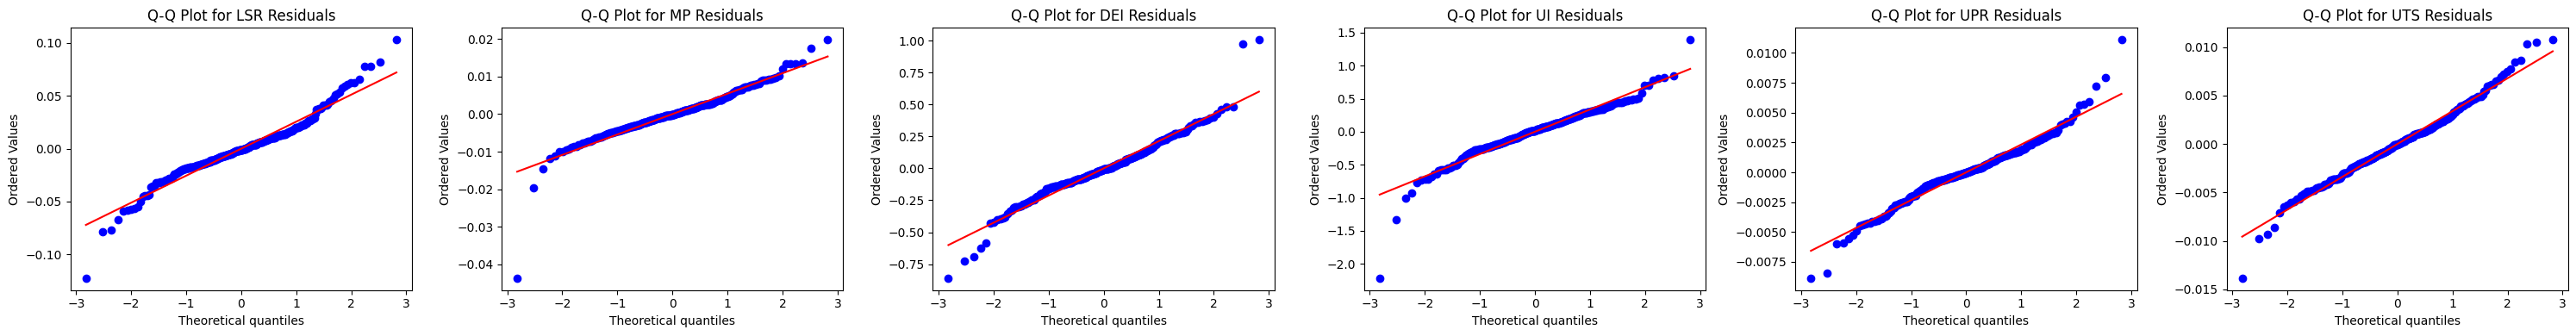


--- Plotting Autocorrelation Function of the First Column: LSR ---


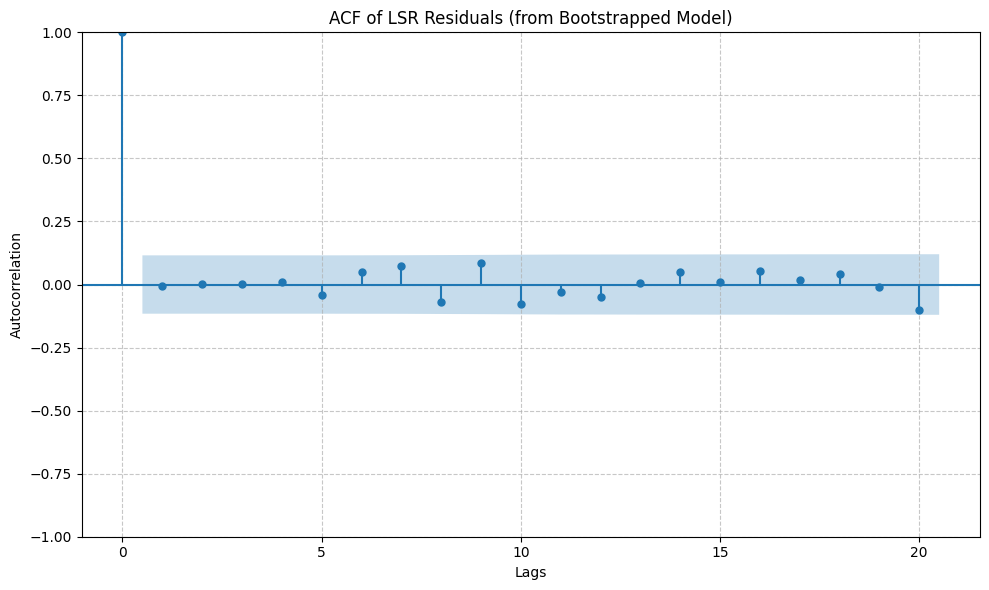

In [581]:
#Nomarlity Check for VAR Residuals
import statsmodels.stats.api as sms

# After fitting your VAR model (results object from above)
# Access residuals: results.resid (This is a pandas DataFrame)

bootstrapped_residuals = bootstrap_results['last_bootstrap_residuals']


# Jarque-Bera test for each residual series
for col in bootstrapped_residuals.columns:
    jb_test = sms.jarque_bera(results.resid[col])
    print(f"\nJarque-Bera Test for {col} residuals:")
    print(f"Statistic: {jb_test[0]:.4f}, P-value: {jb_test[1]:.4f}")
    print(f"Skewness: {jb_test[2]:.4f}, Kurtosis: {jb_test[3]:.4f}")

# You can also plot Q-Q plots for visual inspection:
import matplotlib.pyplot as plt
import scipy.stats as stats

fig, axes = plt.subplots(1, results.resid.shape[1], figsize=(5 * results.resid.shape[1], 4))
if results.resid.shape[1] == 1:
    axes = [axes] # Ensure axes is iterable even for a single series
for i, col in enumerate(results.resid.columns):
    stats.probplot(results.resid[col], dist="norm", plot=axes[i])
    axes[i].set_title(f'Q-Q Plot for {col} Residuals')
plt.tight_layout()
plt.show()


if bootstrapped_residuals is not None and not bootstrapped_residuals.empty:
    # 1. Select the first column
    # You can select by index (0)
    first_column_data = bootstrapped_residuals.iloc[:, 0]
    first_column_name = bootstrapped_residuals.columns[0] # Get the name for the title

    print(f"\n--- Plotting Autocorrelation Function of the First Column: {first_column_name} ---")

    # 2. Create a single figure and a single subplot (Axes)
    fig, ax = plt.subplots(1, 1, figsize=(10, 6)) # A single plot, adjust figsize as needed

    # 3. Plot ACF for the first column onto this single axis
    plot_acf(first_column_data, ax=ax, lags=20,
             title=f'ACF of {first_column_name} Residuals (from Bootstrapped Model)')
    ax.set_xlabel('Lags')
    ax.set_ylabel('Autocorrelation')
    ax.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout() # Adjusts subplot params for a tight layout
    plt.show()         # Displays the figure

else:
    print("No bootstrapped residuals available or DataFrame is empty to plot autocorrelation.")

The bootstrapped residuals are not normal. Since the undelying data is financial data this behaviour is expected. When using residual bootstrapping, the issue of non normal residuals does not occur anymore, as bootstrapping approximates the true distribution of the residuals without strict assumptions, which the VAR model requires. The model is now robust and valid for inference.

Shock           LSR                            MP                      \
Statistic       IRF Lower 95% Upper 95%       IRF Lower 95% Upper 95%   
Horizon                                                                 
0          1.000000  1.000000  1.000000  0.000000  0.000000  0.000000   
1         -0.016939 -0.135334  0.101455 -0.177799 -0.204876 -0.150721   
2         -0.091136 -0.209373  0.027101 -0.041097 -0.068559 -0.013635   
3          0.010081 -0.022302  0.042464 -0.018850 -0.025268 -0.012433   
4          0.014308 -0.011794  0.040411 -0.081461 -0.084353 -0.078569   
5          0.002375 -0.006008  0.010757 -0.040220 -0.041654 -0.038787   
6          0.003355 -0.004899  0.011610 -0.029706 -0.030921 -0.028492   
7          0.003861 -0.002169  0.009891 -0.027737 -0.028851 -0.026623   
8          0.003386 -0.002156  0.008927 -0.026099 -0.027109 -0.025088   
9          0.003100 -0.002208  0.008409 -0.024175 -0.025123 -0.023227   
10         0.002931 -0.002074  0.007935 -0.022672 -

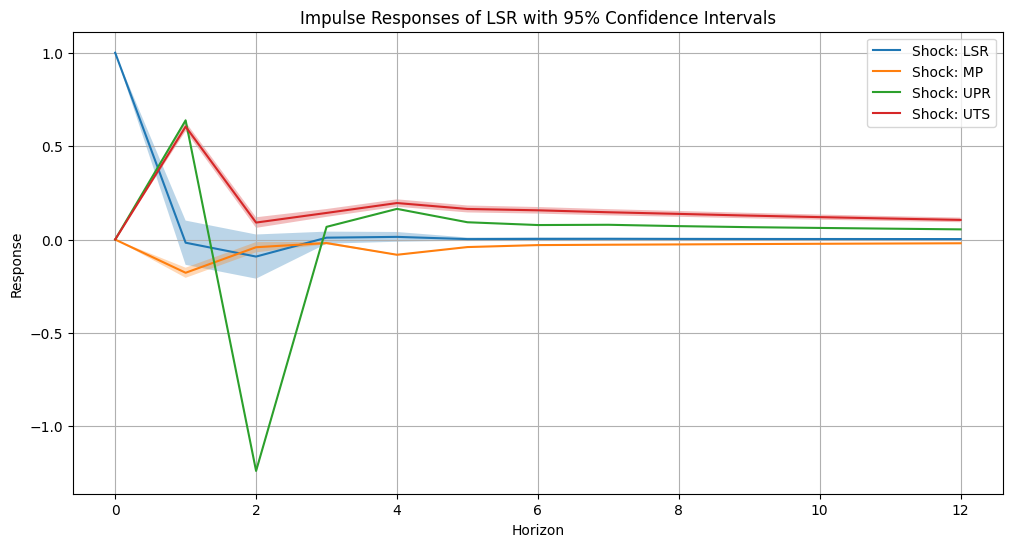

In [624]:
#Bootstrap Impulse Response Function

bootstrap_irfs = bootstrap_results['bootstrap_model'].irf(12)
irf_values = bootstrap_irfs.irfs
lsr_responses = irf_values[:, 0, :]

horizon = irf_values.shape[0] - 1
variable_names = bootstrap_results['bootstrap_model'].names


covmatrices = bootstrap_irfs.cov()

n_vars = len(variable_names)
lower_bound = np.empty_like(lsr_responses)
upper_bound = np.empty_like(lsr_responses)

lsr_index = bootstrap_results['bootstrap_model'].names.index('LSR')

alpha = 0.05
z = 1.96  # for ~95% CI


for t in range(horizon+1):
    covariance = covmatrices[t]  # shape (n_vars*n_vars, n_vars*n_vars)
    for j in range(n_vars):
        idx = 0 * n_vars + j  # response LSR (0), shock j
        se = np.sqrt(covariance[idx, idx])  # standard error
        lower_bound[t, j] = lsr_responses[t, j] - z * se
        upper_bound[t, j] = lsr_responses[t, j] + z * se

lsr_irf_df = pd.DataFrame(lsr_responses, columns=variable_names)
lsr_irf_df.index.name = 'horizon'



# Create MultiIndex columns for response, shock, and bounds
columns = pd.MultiIndex.from_product(
    [variable_names, ['IRF', 'Lower 95%', 'Upper 95%']],
    names=['Shock', 'Statistic']
)

# Create combined DataFrame
data = np.empty((horizon+1, n_vars*3))
for j in range(n_vars):
    data[:, j*3] = lsr_responses[:, j]
    data[:, j*3 + 1] = lower_bound[:, j]
    data[:, j*3 + 2] = upper_bound[:, j]

lsr_irf_df = pd.DataFrame(data, columns=columns)
lsr_irf_df.index.name = 'Horizon'

print(lsr_irf_df)

plt.figure(figsize=(12, 6))

for j, shock_name in enumerate(variable_names):
    plt.plot(lsr_irf_df.index, lsr_irf_df[(shock_name, 'IRF')], label=f'Shock: {shock_name}')
    plt.fill_between(
        lsr_irf_df.index,
        lsr_irf_df[(shock_name, 'Lower 95%')],
        lsr_irf_df[(shock_name, 'Upper 95%')],
        alpha=0.3
    )

plt.title('Impulse Responses of LSR with 95% Confidence Intervals')
plt.xlabel('Horizon')
plt.ylabel('Response')
plt.legend()
plt.grid(True)
plt.show()

#Latex Export of IRF values
# Example variable names and horizons
variable_names = bootstrap_results['bootstrap_model'].names
horizon = lsr_irf_df.index.max()

# Prepare a dictionary to hold rows by variable
rows = {}

for shock in variable_names:
    # For each statistic, get the horizon values as a list
    irf_vals = lsr_irf_df[(shock, 'IRF')].values
    lower_vals = lsr_irf_df[(shock, 'Lower 95%')].values
    upper_vals = lsr_irf_df[(shock, 'Upper 95%')].values
    
    # Combine into one flat list for this shock: IRF at each horizon, then lower at each horizon, then upper at each horizon
    combined = []
    for t in range(horizon+1):
        combined.append(irf_vals[t])
    for t in range(horizon+1):
        combined.append(lower_vals[t])
    for t in range(horizon+1):
        combined.append(upper_vals[t])
    
    rows[shock] = combined

#horizon = lsr_responses.shape[0] - 1
#n_vars = len(variable_names)

# Build MultiIndex columns: one column group per shock variable
column_tuples = []
for var in variable_names:
    column_tuples.extend([
        (var, 'IRF'),
        (var, 'Lower'),
        (var, 'Upper')
    ])
columns = pd.MultiIndex.from_tuples(column_tuples, names=["Shock", "Statistic"])

# Fill the data row by row for each time horizon
data = []
for t in range(horizon + 1):
    row = []
    for j in range(n_vars):
        row.extend([
            lsr_responses[t, j],
            lower_bound[t, j],
            upper_bound[t, j]
        ])
    data.append(row)

# Create the final DataFrame
final_df = pd.DataFrame(data, columns=columns)
final_df.insert(0, "Horizon", range(horizon + 1))

# Get actual column tuples
cols = final_df.columns.tolist()

# Separate Horizon column (single level) from the others
horizon_col = [col for col in cols if not isinstance(col, tuple)]
irf_cols = [col for col in cols if isinstance(col, tuple)]

# Define variable groups
first_vars = variable_names[:3]  # e.g., ['LSR', 'MP', 'UI']
second_vars = variable_names[3:]  # e.g., ['UPR', 'UTS']

# Build correct column selections by checking what's available
first_group_cols = [col for col in irf_cols if col[0] in first_vars]
second_group_cols = [col for col in irf_cols if col[0] in second_vars]

# Reconstruct DataFrames
first_df = final_df[horizon_col + first_group_cols]
second_df = final_df[horizon_col + second_group_cols]

def custom_latex_table(df, caption, label, filename):
    from io import StringIO

    # Export initial LaTeX with multirow headers
    latex = df.to_latex(
        index=False,
        float_format="%.4f",
        multicolumn=True,
        multicolumn_format='c',
        longtable=True,
        escape=False
    )

    # Now inject caption and label manually into longtable structure
    latex_lines = latex.splitlines()

    # Identify the start of the longtable (where we will inject caption/label)
    start_idx = next(i for i, line in enumerate(latex_lines) if r'\begin{longtable}' in line)

    # Insert caption and label just after \begin{longtable}
    latex_lines.insert(start_idx + 1, f"\\caption{{{caption}}}\\\\")
    latex_lines.insert(start_idx + 2, f"\\label{{{label}}}\\\\")
    
    # Write to file
    with open(filename, "w") as f:
        f.write('\n'.join(latex_lines))


# Export two subtables
custom_latex_table(
    df=first_df,
    caption="Impulse Responses of LSR (Variables: LSR, MP, UI)",
    label="tab:lsr_irf_group1",
    filename="lsr_irf_group1.tex"
)

custom_latex_table(
    df=second_df,
    caption="Impulse Responses of LSR (Variables: UPR, UTS)",
    label="tab:lsr_irf_group2",
    filename="lsr_irf_group2.tex"
)



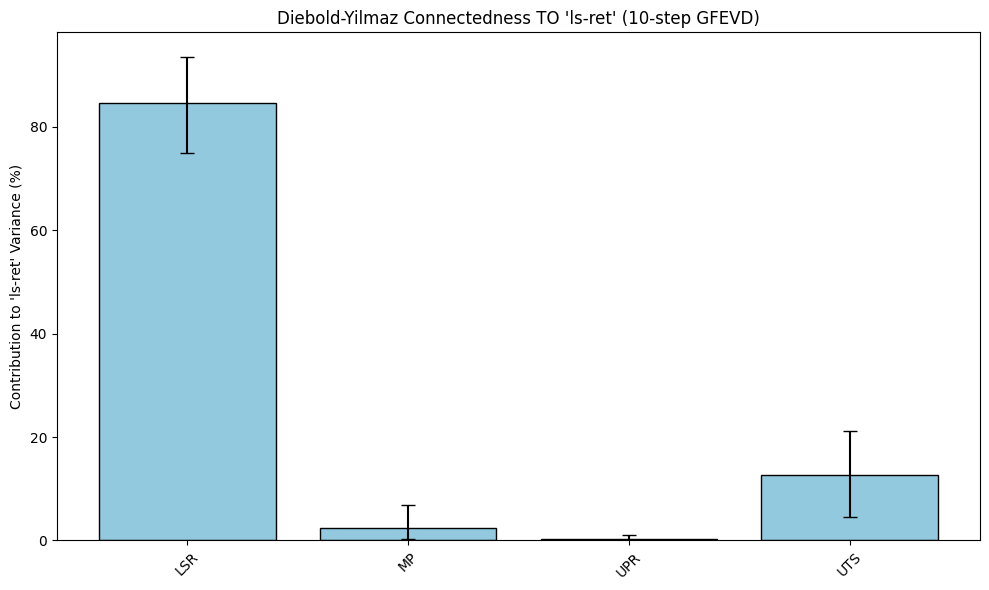

'""\ngfevd_matrix = compute_gfevd(bootstrap_results[\'bootstrap_coefficients\'], horizon=10)\nls_ret_contributions = gfevd_matrix[ls_ret_index, :]\n'

In [625]:
#Connectedness measures from Diebold-Yildiz (2014)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

gfevd_bootstrap = []



def compute_gfevd(var_result, horizon=10):
    """
    Compute Generalized Forecast Error Variance Decomposition (GFEVD)
    Based on Pesaran & Shin (1998)
    """
    sigma_u = var_result.sigma_u  # residual covariance matrix
    Phi = var_result.ma_rep(maxn=horizon)  # MA coefficient matrices

    K = sigma_u.shape[0]
    fevd = np.zeros((K, K))  # [dependent_var, shock_var]

    for j in range(K):  # for each shock
        ej = np.zeros(K)
        ej[j] = 1.0
        for h in range(horizon):
            phi_h = Phi[h]
            num = (phi_h @ sigma_u @ ej) ** 2
            den = np.diag(phi_h @ sigma_u @ phi_h.T)
            fevd[:, j] += num / den

    # Normalize rows to sum to 1
    fevd_normalized = fevd / fevd.sum(axis=1)[:, None]
    return fevd_normalized

for fit in bootstrap_results['bootstrap_fits']:
    try:
        g = compute_gfevd(fit, horizon=10)
        gfevd_bootstrap.append(g)
    except Exception as e:
        continue

ls_ret_index = fit.names.index('LSR')
ls_ret_contribs = [g[ls_ret_index] for g in gfevd_bootstrap]
ls_ret_contribs = np.array(ls_ret_contribs)  # shape: (n_bootstrap, n_vars)

mean_contrib = np.mean(ls_ret_contribs, axis=0)
ci_lower = np.percentile(ls_ret_contribs, 2.5, axis=0)
ci_upper = np.percentile(ls_ret_contribs, 97.5, axis=0)

labels = fit.names

plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=mean_contrib*100, color='skyblue', edgecolor='k')
plt.errorbar(x=np.arange(len(labels)), y=mean_contrib*100,
             yerr=[(mean_contrib - ci_lower)*100, (ci_upper - mean_contrib)*100],
             fmt='none', ecolor='black', capsize=5)
plt.ylabel("Contribution to 'ls-ret' Variance (%)")
plt.title("Diebold-Yilmaz Connectedness TO 'ls-ret' (10-step GFEVD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


"""""
gfevd_matrix = compute_gfevd(bootstrap_results['bootstrap_coefficients'], horizon=10)
ls_ret_contributions = gfevd_matrix[ls_ret_index, :]
"""


In [545]:
bootstrap_results['bootstrap_fits']